# **Deep Dive Analysis: The Data Analyst Career Path**

##  **Project Overview**
While the Data Science field is broad, the specific role of a **Data Analyst** is often the entry point for many professionals. This project performs a targeted analysis on the `ds_salaries` dataset to investigate the career trajectory, compensation structure (converted to IDR), and best locations for Data Analysts.

## **Key Objectives**
1.  **Data Quality Assessment:** Ensure data integrity by checking for NULL values.
2.  **Salary Estimation (IDR):** Calculate estimated monthly salaries in Indonesian Rupiah for various experience levels.
3.  **Global Opportunities:** Identify countries offering competitive salaries for Entry and Mid-level analysts.
4.  **Career Growth:** Analyze the salary leap from Mid-level to Executive positions using CTEs (Common Table Expressions).

---

### **1. Environment Setup & Data Ingestion**
We begin by importing necessary libraries and loading the CSV data into an **in-memory SQLite database**. This allows us to execute SQL queries directly within Python.

In [ ]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

conn = sqlite3.connect(':memory:')
df = pd.read_csv('ds_salaries.csv')
df.to_sql('ds_salaries', conn, index=False, if_exists='replace')

print(" Database Ready! Kita siap jalankan script SQL Modul 11.")

 Database Ready! Kita siap jalankan script SQL Modul 11.


### **2. Data Quality Check**
Before analyzing, we must validate the dataset. The following query checks for any `NULL` values across key columns to ensure our analysis is based on complete data.

In [ ]:
from IPython.display import display

query_1 = """
SELECT *
FROM ds_salaries
WHERE work_year IS NULL
   OR experience_level IS NULL
   OR employment_type IS NULL
   OR job_title IS NULL
   OR salary IS NULL
   OR salary_currency IS NULL
   OR salary_in_usd IS NULL
   OR employee_residence IS NULL
   OR remote_ratio IS NULL
   OR company_location IS NULL
   OR company_size IS NULL;
"""

df_check = pd.read_sql(query_1, conn)

print(f"Jumlah baris data NULL: {len(df_check)}")
if len(df_check) == 0:
    print(" Data Bersih! Tidak ada NULL, siap dianalisa.")
else:
    display(df_check)

Jumlah baris data NULL: 0
 Data Bersih! Tidak ada NULL, siap dianalisa.


### **3. Scope Definition: Filtering for Data Analysts**
The dataset contains various data roles. We will filter the `job_title` to focus specifically on roles containing the keyword **"Data Analyst"** to narrow down our analysis scope.

In [4]:
query_3 = """
SELECT DISTINCT job_title
FROM ds_salaries
WHERE job_title LIKE '%data analyst%'
ORDER BY job_title;
"""

df_titles = pd.read_sql(query_3, conn)

print("Variasi Pekerjaan Data Analyst:")
display(df_titles)

Variasi Pekerjaan Data Analyst:


,job_title
0,BI Data Analyst
1,Business Data Analyst
2,Data Analyst
3,Finance Data Analyst
4,Financial Data Analyst
5,Lead Data Analyst
6,Marketing Data Analyst
7,Principal Data Analyst
8,Product Data Analyst


### **4. Monthly Salary Estimation (IDR)**
**Question:** How much can a Data Analyst expect to earn per month in Rupiah?

In this section, we convert the annual USD salary to **Monthly IDR** (assuming an exchange rate of **1 USD = 15,000 IDR**). We analyze the average income across different experience levels:
* **EN:** Entry-level
* **MI:** Mid-level
* **SE:** Senior-level
* **EX:** Executive-level

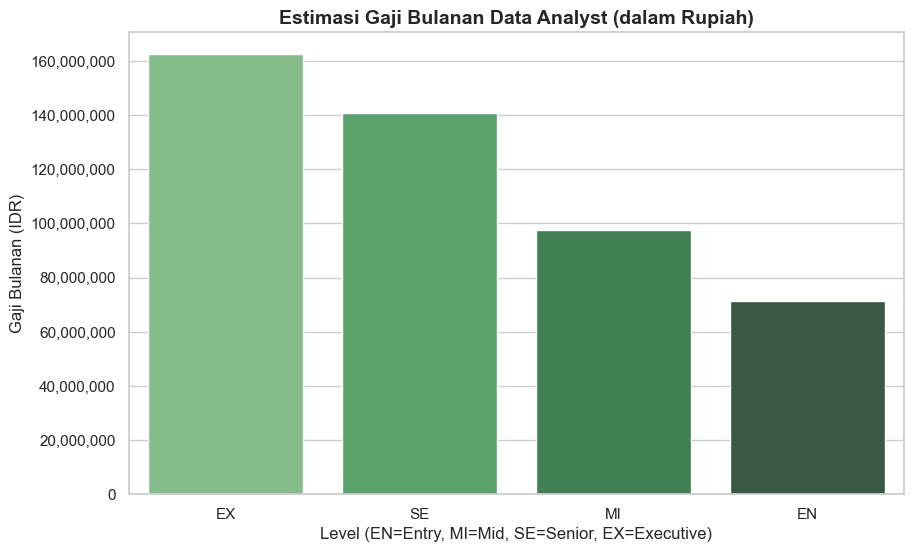

,experience_level,avg_sal_rp_monthly
0,EX,1.625000e+08
1,SE,1.408270e+08
2,MI,9.742595e+07
3,EN,7.138985e+07


In [ ]:
import matplotlib.ticker as ticker  

query_4_1 = """
SELECT
    experience_level,
    (AVG(salary_in_usd) * 15000) / 12 AS avg_sal_rp_monthly
FROM ds_salaries
WHERE job_title LIKE '%data analyst%'
GROUP BY experience_level
ORDER BY avg_sal_rp_monthly DESC;
"""

df_salary_idr = pd.read_sql(query_4_1, conn)


plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_salary_idr, 
    x='experience_level', 
    y='avg_sal_rp_monthly', 
    hue='experience_level', 
    legend=False, 
    palette='Greens_d'
)

plt.title('Estimasi Gaji Bulanan Data Analyst (dalam Rupiah)', fontsize=14, fontweight='bold')
plt.ylabel('Gaji Bulanan (IDR)')
plt.xlabel('Level (EN=Entry, MI=Mid, SE=Senior, EX=Executive)')

ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))

plt.show()
display(df_salary_idr)

### **5. Top Countries for Data Analysts (Entry & Mid Level)**
**Question:** Which countries offer the best salaries (> $20k) for early-career analysts?

We filter for **Full-Time (FT)** roles at **Entry (EN)** and **Mid (MI)** levels to find the most lucrative locations for professionals starting their journey.

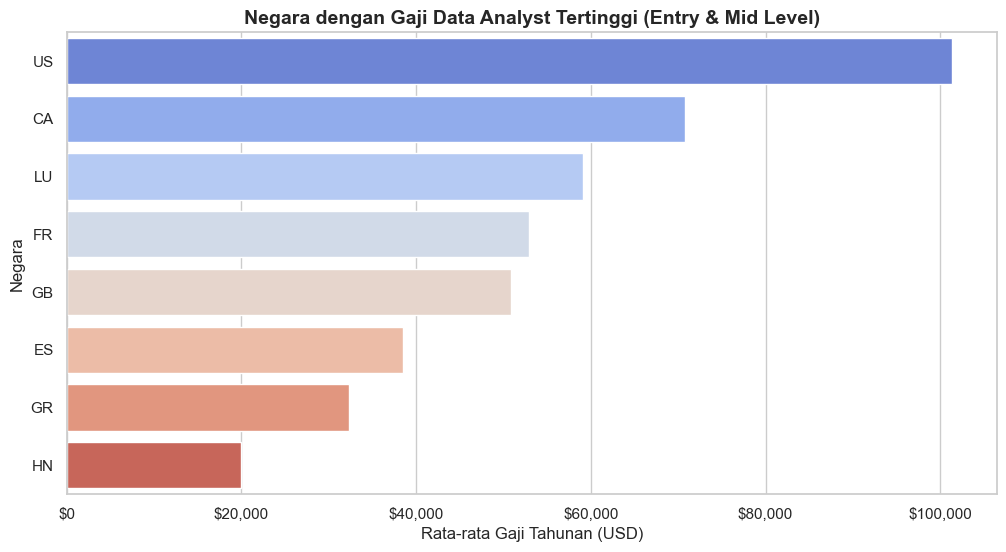

In [11]:
query_5 = """
SELECT
    company_location,
    AVG(salary_in_usd) as avg_sal_in_usd
FROM ds_salaries
WHERE job_title LIKE '%data analyst%'
    AND employment_type = 'FT'
    AND experience_level IN ('MI', 'EN')
GROUP BY company_location
HAVING avg_sal_in_usd >= 20000
ORDER BY avg_sal_in_usd DESC;
"""

df_country = pd.read_sql(query_5, conn)

plt.figure(figsize=(12, 6))


sns.barplot(
    data=df_country, 
    x='avg_sal_in_usd', 
    y='company_location', 
    hue='company_location', 
    legend=False, 
    palette='coolwarm'
)

plt.title('Negara dengan Gaji Data Analyst Tertinggi (Entry & Mid Level)', fontsize=14, fontweight='bold')
plt.xlabel('Rata-rata Gaji Tahunan (USD)')
plt.ylabel('Negara')

ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '${:,.0f}'.format(x)))

plt.show()

### **6. Career Growth Analysis: Mid-Level vs. Executive**
**Question:** How significant is the salary jump when reaching the Executive level?

Using **Common Table Expressions (CTEs)**, we compare the annual average salary gap between **Mid-level (MI)** and **Executive (EX)** Data Analysts over the years.

> **Note:** If the result shows `NaN` for a specific year (e.g., 2020), it indicates that there were no recorded Executive Data Analyst positions in the dataset for that year.

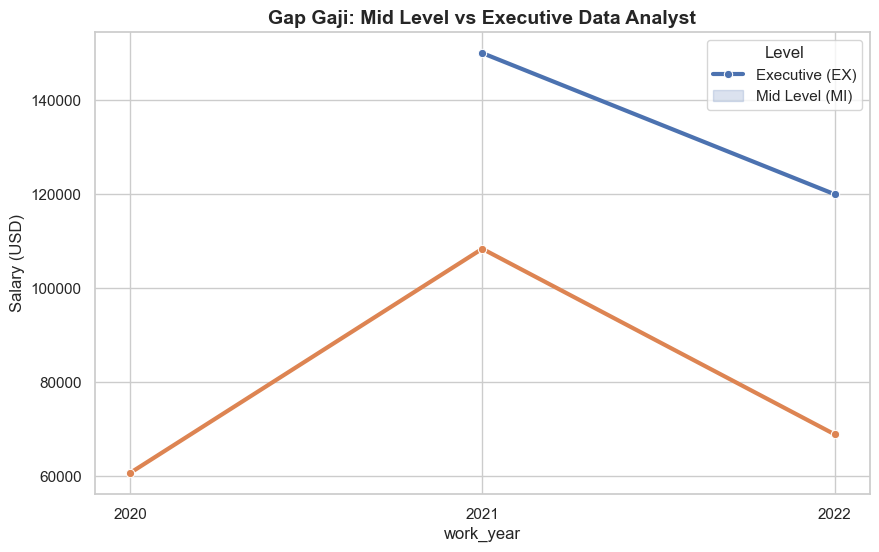

,work_year,sal_in_usd_ex,sal_in_usd_mi,differences
0,2020,NaN,60728.875000,NaN
1,2021,150000.0,108398.818182,41601.181818
2,2022,120000.0,68970.590909,51029.409091


In [8]:
query_6 = """
WITH ds_1 AS (
    SELECT
        work_year,
        AVG(salary_in_usd) sal_in_usd_ex
    FROM ds_salaries
    WHERE employment_type = 'FT'
        AND experience_level = 'EX'
        AND job_title LIKE '%data analyst%'
    GROUP BY work_year
),
ds_2 AS (
    SELECT
        work_year,
        AVG(salary_in_usd) sal_in_usd_mi
    FROM ds_salaries
    WHERE employment_type = 'FT'
        AND experience_level = 'MI'
        AND job_title LIKE '%data analyst%'
    GROUP BY work_year
),
t_year AS (
    SELECT DISTINCT work_year FROM ds_salaries
)
SELECT
    t_year.work_year,
    ds_1.sal_in_usd_ex,
    ds_2.sal_in_usd_mi,
    ds_1.sal_in_usd_ex - ds_2.sal_in_usd_mi as differences
FROM t_year
LEFT JOIN ds_1 ON ds_1.work_year = t_year.work_year
LEFT JOIN ds_2 ON ds_2.work_year = t_year.work_year;
"""

df_growth = pd.read_sql(query_6, conn)


df_growth_melted = df_growth.melt(id_vars=['work_year'], value_vars=['sal_in_usd_ex', 'sal_in_usd_mi'], var_name='Level', value_name='Salary')

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_growth_melted, x='work_year', y='Salary', hue='Level', marker='o', linewidth=3)
plt.title('Gap Gaji: Mid Level vs Executive Data Analyst', fontsize=14, fontweight='bold')
plt.xticks([2020, 2021, 2022])
plt.ylabel('Salary (USD)')
plt.legend(title='Level', labels=['Executive (EX)', 'Mid Level (MI)'])
plt.show()

display(df_growth)

### **Conclusion**
Based on this deep-dive analysis:
1.  **High Earning Potential:** Senior and Executive Data Analysts command significantly higher salaries, showing a strong career progression path.
2.  **Global Opportunities:** Aside from the US, several other countries offer competitive packages for early-career analysts.
3.  **Data Gaps:** The absence of Executive data in 2020 highlights the importance of checking data availability before drawing year-over-year conclusions.

---
*Analysis performed using SQL & Python.*